In [1]:
import matplotlib.pyplot as plt
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.ticker import MaxNLocator
from comparers import ModelComparer, plot_decision_boundary
from diro2c_wrapper import WrappedDiro2C, plot_diro2c_2d, get_pruned_trees, eval_diro2c, get_generated_data
from surrogate_tree import get_feature_importances, plot_feature_importances, plot_surrogate_tree,\
                           extract_rules, print_rules, plot_rules_of_tree_for_class
from util import RuleClassifier, evaluate_counterfactual_fidelity, get_complexity, group_metrics

In [2]:
with open('data/task.pickle', 'rb') as f:
    clf_a, clf_b, X, y, feature_names, feature_precisions = pickle.load(f)

In [3]:
comparer = ModelComparer(clf_a, clf_b, feature_names)

In [4]:
mclass_diff = comparer.predict_mclass_diff(X)

In [5]:
def get_predicted_rules(indices=None):
    indices = np.where(y_true)[0] if indices is None else indices
    pred_node_ids = tree.apply(X[indices])
    node_id_to_rule_no = lambda node_id: np.where(node_ids == node_id)[0][0] + 1 if node_id in node_ids else None
    pred_rule_nos = [node_id_to_rule_no(pred_node_id) for pred_node_id in pred_node_ids]
    return pd.Series(pred_rule_nos, index=indices)

# Explanations

In [5]:
%%time
for class_name in comparer.class_names:
    print(class_name)
    explainer = WrappedDiro2C(X, comparer, class_name)
    explanation = explainer.generate_global_explanation()
    with open(f'explanations/diro2c.{class_name}.pickle', 'wb') as f:
        pickle.dump(explanation, f, pickle.HIGHEST_PROTOCOL)

(0, 0)
(0, 1)
(1, 0)
(1, 1)
CPU times: user 13min 7s, sys: 5.9 s, total: 13min 13s
Wall time: 13min 33s


## (0,1)

In [6]:
focus_class = '(0, 1)'
y_true = comparer.class_names[mclass_diff] == focus_class
class_names = ['other', focus_class]

In [7]:
with open(f'explanations/diro2c.{focus_class}.pickle', 'rb') as f:
    explanation = pickle.load(f)

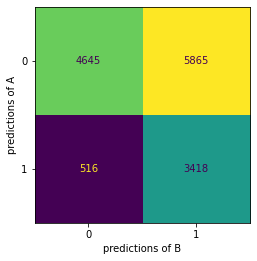

In [8]:
comparer.plot_confusion_matrix(get_generated_data(explanation)[0])
plt.savefig('figures/bign-diro2c-cf-01.pdf')

In [9]:
%%time
trees = get_pruned_trees(explanation)
tree_it = iter(trees)
len(trees)

CPU times: user 346 ms, sys: 6.18 ms, total: 352 ms
Wall time: 426 ms


23

In [10]:
trees[-1].get_depth()

12

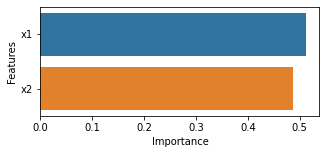

In [11]:
feature_importances, feature_order = get_feature_importances(trees[-1])
plot_feature_importances(feature_names, feature_importances, feature_order)

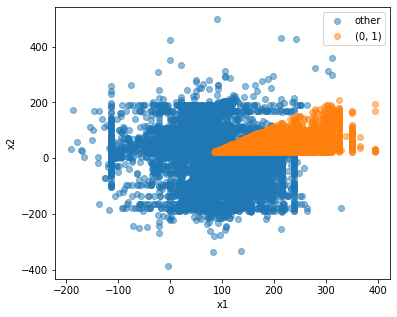

In [12]:
plot_diro2c_2d(explanation, 'x1', 'x2', class_names=class_names)
plt.savefig('figures/bign-diro2c-generated-data-01.pdf', bbox_inches='tight', pad_inches=0)

### 2 Leafs

In [13]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.16818056015717134, 1, 2)

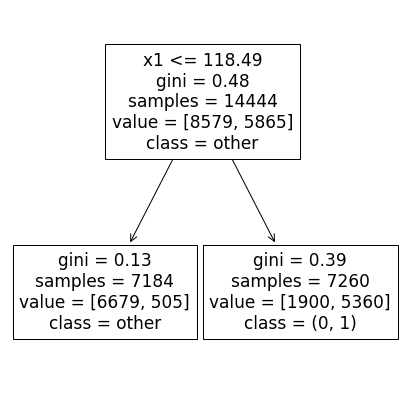

In [14]:
plot_surrogate_tree(tree, feature_names, class_names, precision=2, figsize=(7, 7))

In [15]:
constraints, rules, class_occurences, labels, node_ids, rule_order = extract_rules(tree, feature_names, comparer.difference_classes, precisions=feature_precisions)
print_rules(rules, class_occurences, comparer.class_names, labels)

1. x1 > 118.5 => (0, 1) [1900, 5360]


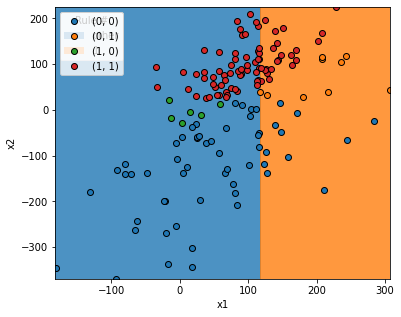

In [16]:
plot_rules_of_tree_for_class(tree, tree.classes_, [tree.classes_[1]], X, mclass_diff, comparer.class_names, feature_names, rule_order)

### 3 Leafs

In [17]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.018749560355942774, 2, 3)

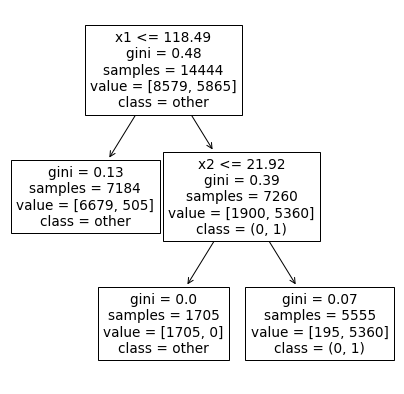

In [18]:
plot_surrogate_tree(tree, feature_names, class_names, precision=2, figsize=(7, 7))

In [19]:
constraints, rules, class_occurences, labels, node_ids, rule_order = extract_rules(tree, feature_names, comparer.difference_classes, precisions=feature_precisions)
print_rules(rules, class_occurences, comparer.class_names, labels)

1. x1 > 118.5 and x2 > 21.9 => (0, 1) [195, 5360]


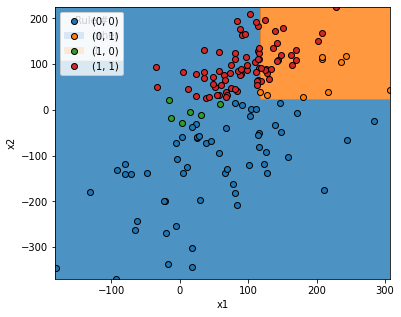

In [20]:
plot_rules_of_tree_for_class(tree, tree.classes_, [tree.classes_[1]], X, mclass_diff, comparer.class_names, feature_names, rule_order)

### 6 Leafs

In [21]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.008883025922501463, 4, 6)

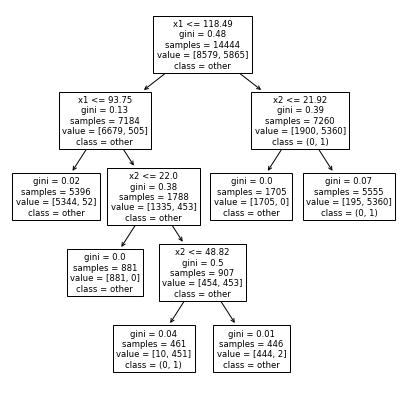

In [22]:
plot_surrogate_tree(tree, feature_names, class_names, precision=2, figsize=(7, 7))

In [23]:
constraints, rules, class_occurences, labels, node_ids, rule_order = extract_rules(tree, feature_names, comparer.difference_classes, precisions=feature_precisions)
print_rules(rules, class_occurences, comparer.class_names, labels)

1. x1 > 118.5 and x2 > 21.9 => (0, 1) [195, 5360]
2. 93.7 < x1 <= 118.5 and 22.0 < x2 <= 48.8 => (0, 1) [10, 451]


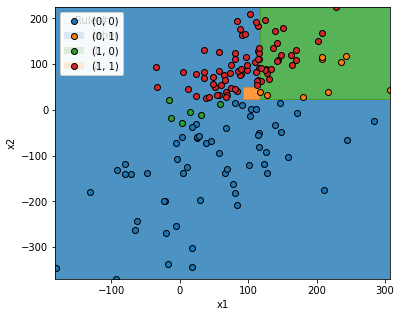

In [24]:
plot_rules_of_tree_for_class(tree, tree.classes_, [tree.classes_[1]], X, mclass_diff, comparer.class_names, feature_names, rule_order)

### 7 Leafs

In [25]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.004726587503410984, 4, 7)

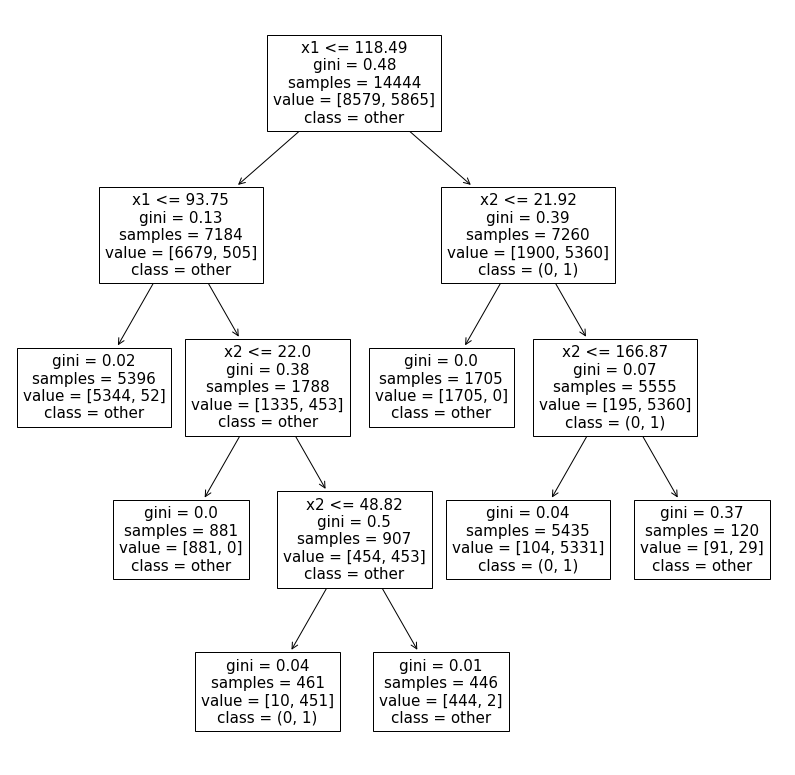

In [26]:
plot_surrogate_tree(tree, feature_names, class_names, precision=2, figsize=(14, 14))

In [27]:
constraints, rules, class_occurences, labels, node_ids, rule_order = extract_rules(tree, feature_names, comparer.difference_classes, precisions=feature_precisions)
print_rules(rules, class_occurences, comparer.class_names, labels)

1. x1 > 118.5 and 21.9 < x2 <= 166.9 => (0, 1) [104, 5331]
2. 93.7 < x1 <= 118.5 and 22.0 < x2 <= 48.8 => (0, 1) [10, 451]


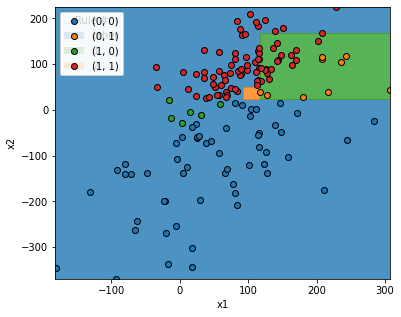

In [28]:
plot_rules_of_tree_for_class(tree, tree.classes_, [tree.classes_[1]], X, mclass_diff, comparer.class_names, feature_names, rule_order)

### 9 Leafs

In [29]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.0025583654322230893, 5, 9)

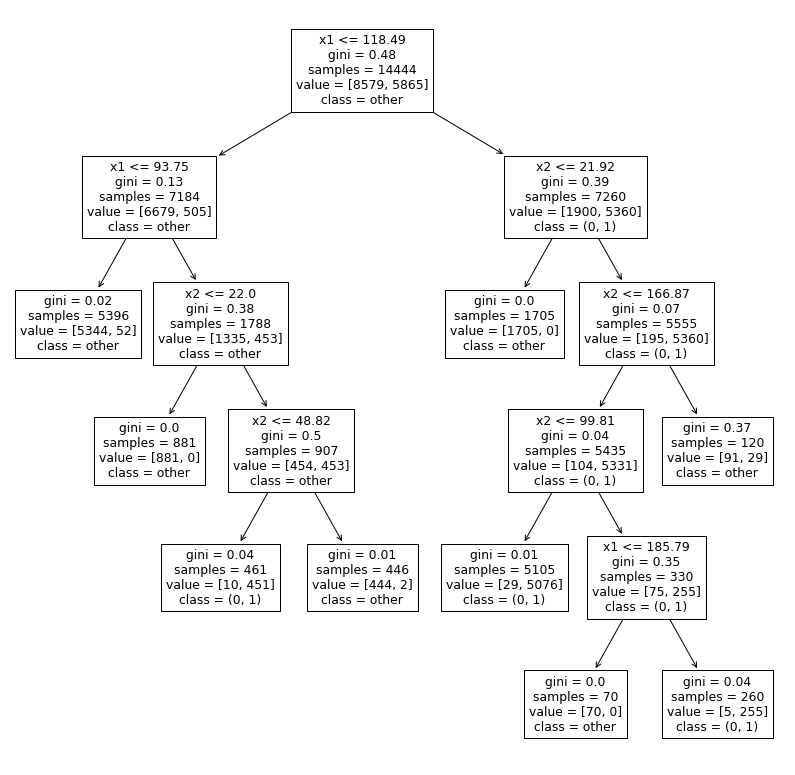

In [30]:
plot_surrogate_tree(tree, feature_names, class_names, precision=2, figsize=(14, 14))

In [31]:
constraints, rules, class_occurences, labels, node_ids, rule_order = extract_rules(tree, feature_names, comparer.difference_classes, precisions=feature_precisions)
print_rules(rules, class_occurences, comparer.class_names, labels)

1. x1 > 118.5 and 21.9 < x2 <= 99.8 => (0, 1) [29, 5076]
2. 93.7 < x1 <= 118.5 and 22.0 < x2 <= 48.8 => (0, 1) [10, 451]
3. x1 > 185.8 and 99.8 < x2 <= 166.9 => (0, 1) [5, 255]


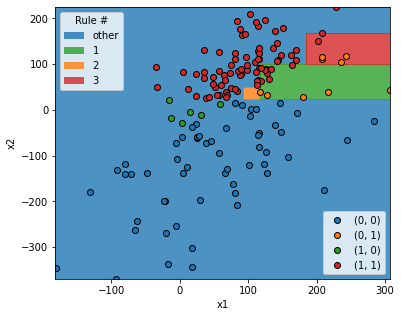

In [32]:
plot_rules_of_tree_for_class(tree, tree.classes_, [tree.classes_[1]], X, mclass_diff, comparer.class_names, feature_names, rule_order)
ax = plt.gca()
ax.get_legend().remove()
ax.legend(*ax.get_legend_handles_labels(), loc='lower right')
plt.savefig('figures/bign-diro2c-final-01.pdf', bbox_inches='tight', pad_inches=0)

In [33]:
pred_rules = get_predicted_rules()
indices_not_explained = pred_rules.index[pd.isna(pred_rules)].tolist()
indices_not_explained

[]

## $(1,0)$

In [34]:
focus_class = '(1, 0)'
y_true = comparer.class_names[mclass_diff] == focus_class
class_names = ['other', focus_class]

In [35]:
with open(f'explanations/diro2c.{focus_class}.pickle', 'rb') as f:
    explanation = pickle.load(f)

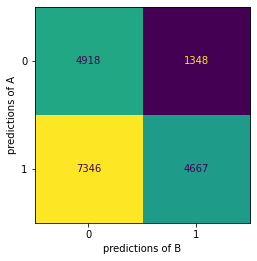

In [36]:
comparer.plot_confusion_matrix(get_generated_data(explanation)[0])
plt.savefig('figures/bign-diro2c-cf-10.pdf')

In [37]:
%%time
trees = get_pruned_trees(explanation)
tree_it = iter(trees)
len(trees)

CPU times: user 927 ms, sys: 16.5 ms, total: 944 ms
Wall time: 1.1 s


48

In [38]:
trees[-1].get_depth()

13

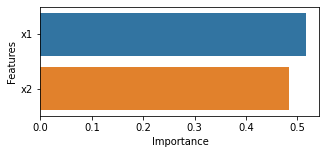

In [39]:
feature_importances, feature_order = get_feature_importances(trees[-1])
plot_feature_importances(feature_names, feature_importances, feature_order)

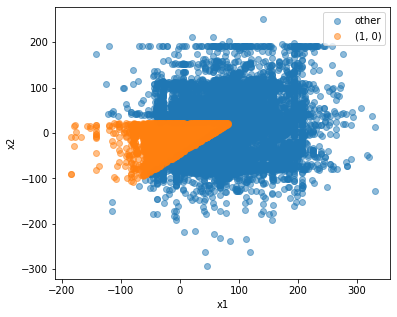

In [40]:
plot_diro2c_2d(explanation, 'x1', 'x2', class_names=class_names)
plt.savefig('figures/bign-diro2c-generated-data-10.pdf', bbox_inches='tight', pad_inches=0)

### 2 Leafs

In [41]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.10218290812148145, 1, 2)

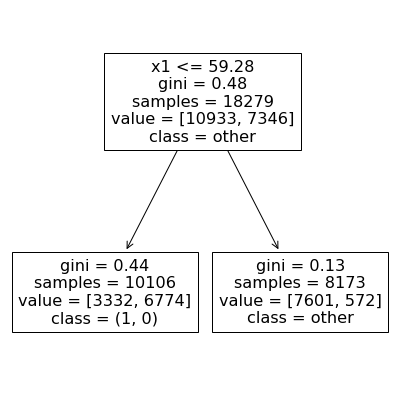

In [42]:
plot_surrogate_tree(tree, feature_names, class_names, precision=2, figsize=(7, 7))

In [43]:
constraints, rules, class_occurences, labels, node_ids, rule_order = extract_rules(tree, feature_names, comparer.difference_classes, precisions=feature_precisions)
print_rules(rules, class_occurences, comparer.class_names, labels)

1. x1 <= 59.3 => (0, 1) [3332, 6774]


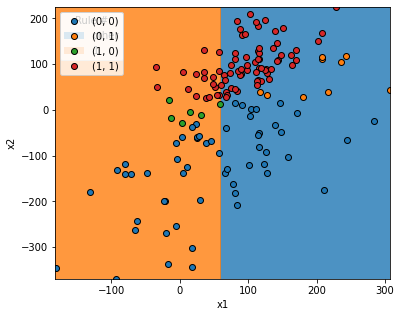

In [44]:
plot_rules_of_tree_for_class(tree, tree.classes_, [tree.classes_[1]], X, mclass_diff, comparer.class_names, feature_names, rule_order)

### 3 Leafs

In [45]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.05095453450923265, 2, 3)

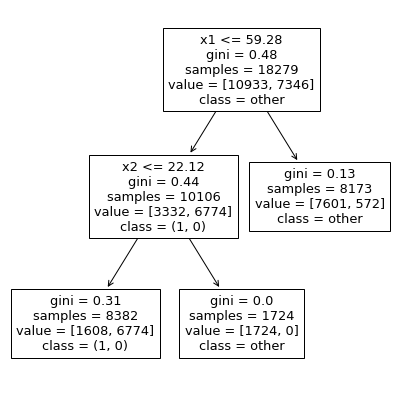

In [46]:
plot_surrogate_tree(tree, feature_names, class_names, precision=2, figsize=(7, 7))

In [47]:
constraints, rules, class_occurences, labels, node_ids, rule_order = extract_rules(tree, feature_names, comparer.difference_classes, precisions=feature_precisions)
print_rules(rules, class_occurences, comparer.class_names, labels)

1. x1 <= 59.3 and x2 <= 22.1 => (0, 1) [1608, 6774]


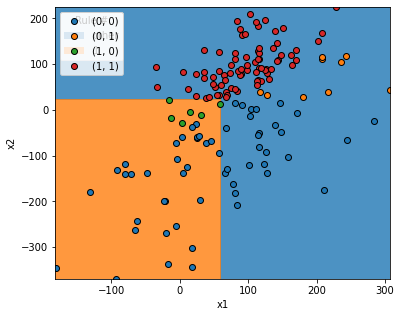

In [48]:
plot_rules_of_tree_for_class(tree, tree.classes_, [tree.classes_[1]], X, mclass_diff, comparer.class_names, feature_names, rule_order)

### 4 Leafs

In [49]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.030413352908594544, 3, 4)

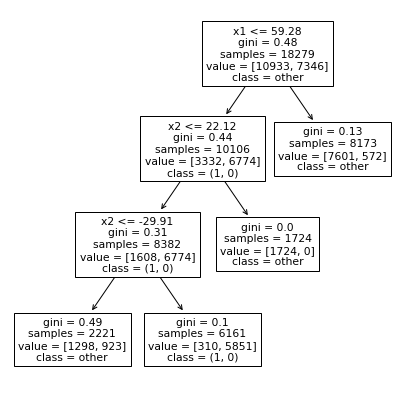

In [50]:
plot_surrogate_tree(tree, feature_names, class_names, precision=2, figsize=(7, 7))

In [51]:
constraints, rules, class_occurences, labels, node_ids, rule_order = extract_rules(tree, feature_names, comparer.difference_classes, precisions=feature_precisions)
print_rules(rules, class_occurences, comparer.class_names, labels)

1. x1 <= 59.3 and -29.9 < x2 <= 22.1 => (0, 1) [310, 5851]


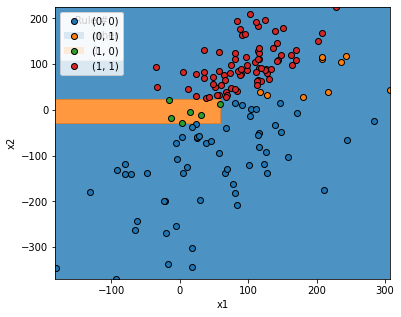

In [52]:
plot_rules_of_tree_for_class(tree, tree.classes_, [tree.classes_[1]], X, mclass_diff, comparer.class_names, feature_names, rule_order)

### 5 Leafs

In [53]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.016560707773399155, 4, 5)

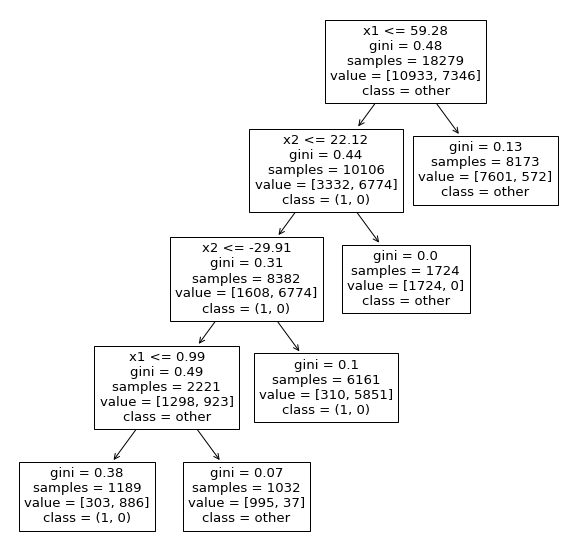

In [54]:
plot_surrogate_tree(tree, feature_names, class_names, precision=2, figsize=(10, 10))

In [55]:
constraints, rules, class_occurences, labels, node_ids, rule_order = extract_rules(tree, feature_names, comparer.difference_classes, precisions=feature_precisions)
print_rules(rules, class_occurences, comparer.class_names, labels)

1. x1 <= 59.3 and -29.9 < x2 <= 22.1 => (0, 1) [310, 5851]
2. x1 <= 1.0 and x2 <= -29.9 => (0, 1) [303, 886]


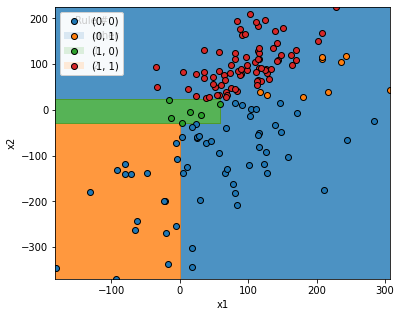

In [56]:
plot_rules_of_tree_for_class(tree, tree.classes_, [tree.classes_[1]], X, mclass_diff, comparer.class_names, feature_names, rule_order)

### 8 Leafs

In [57]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.007464896717550013, 4, 8)

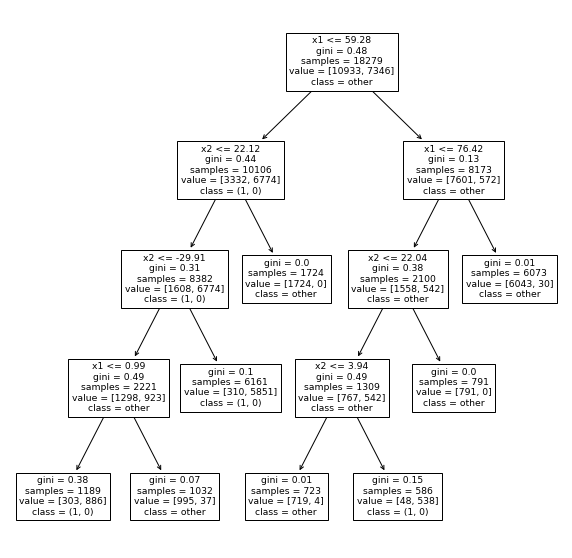

In [58]:
plot_surrogate_tree(tree, feature_names, class_names, precision=2, figsize=(10, 10))

In [59]:
constraints, rules, class_occurences, labels, node_ids, rule_order = extract_rules(tree, feature_names, comparer.difference_classes, precisions=feature_precisions)
print_rules(rules, class_occurences, comparer.class_names, labels)

1. x1 <= 59.3 and -29.9 < x2 <= 22.1 => (0, 1) [310, 5851]
2. x1 <= 1.0 and x2 <= -29.9 => (0, 1) [303, 886]
3. 59.3 < x1 <= 76.4 and 3.9 < x2 <= 22.0 => (0, 1) [48, 538]


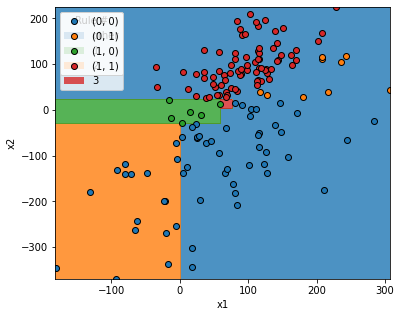

In [60]:
plot_rules_of_tree_for_class(tree, tree.classes_, [tree.classes_[1]], X, mclass_diff, comparer.class_names, feature_names, rule_order)

### 10 Leafs

In [61]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.0051036106041802, 5, 10)

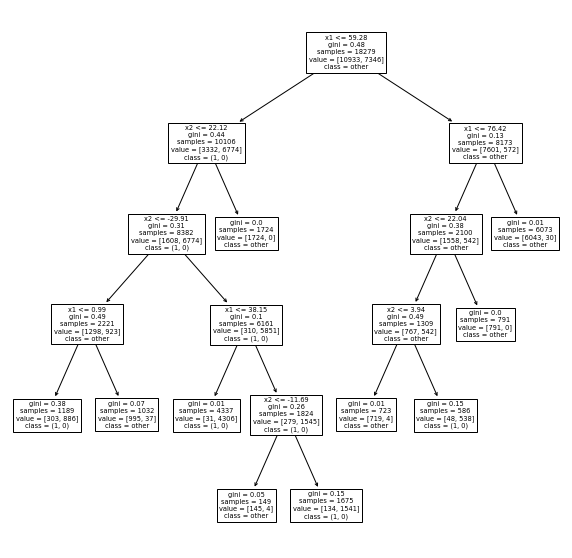

In [62]:
plot_surrogate_tree(tree, feature_names, class_names, precision=2, figsize=(10, 10))

In [63]:
constraints, rules, class_occurences, labels, node_ids, rule_order = extract_rules(tree, feature_names, comparer.difference_classes, precisions=feature_precisions)
print_rules(rules, class_occurences, comparer.class_names, labels)

1. x1 <= 38.2 and -29.9 < x2 <= 22.1 => (0, 1) [31, 4306]
2. 38.2 < x1 <= 59.3 and -11.7 < x2 <= 22.1 => (0, 1) [134, 1541]
3. x1 <= 1.0 and x2 <= -29.9 => (0, 1) [303, 886]
4. 59.3 < x1 <= 76.4 and 3.9 < x2 <= 22.0 => (0, 1) [48, 538]


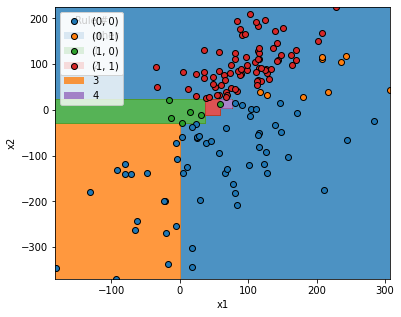

In [64]:
plot_rules_of_tree_for_class(tree, tree.classes_, [tree.classes_[1]], X, mclass_diff, comparer.class_names, feature_names, rule_order)

### 11 Leafs

In [65]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.0045365383538313025, 5, 11)

In [66]:
constraints, rules, class_occurences, labels, node_ids, rule_order = extract_rules(tree, feature_names, comparer.difference_classes, precisions=feature_precisions)
print_rules(rules, class_occurences, comparer.class_names, labels)

1. x1 <= 38.2 and -29.9 < x2 <= 22.1 => (0, 1) [31, 4306]
2. 38.2 < x1 <= 59.3 and -11.7 < x2 <= 22.1 => (0, 1) [134, 1541]
3. x1 <= 1.0 and -79.7 < x2 <= -29.9 => (0, 1) [180, 845]
4. 59.3 < x1 <= 76.4 and 3.9 < x2 <= 22.0 => (0, 1) [48, 538]


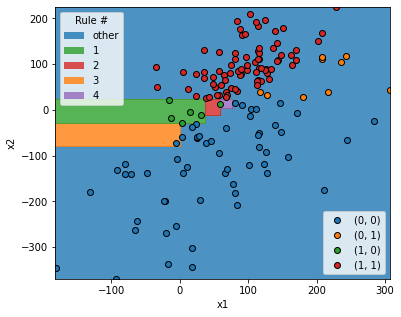

In [67]:
plot_rules_of_tree_for_class(tree, tree.classes_, [tree.classes_[1]], X, mclass_diff, comparer.class_names, feature_names, rule_order)
ax = plt.gca()
ax.get_legend().remove()
ax.legend(*ax.get_legend_handles_labels(), loc='lower right')
plt.savefig('figures/bign-diro2c-final-10.pdf', bbox_inches='tight', pad_inches=0)

In [68]:
pred_rules = get_predicted_rules()
indices_not_explained = pred_rules.index[pd.isna(pred_rules)].tolist()
indices_not_explained

[]

# Evaluation

In [6]:
with open('data/test.pickle', 'rb') as f:
    X_test, y_test = pickle.load(f)

In [7]:
explanations_per_class = {}
for class_name in comparer.class_names:
    with open(f'explanations/diro2c.{class_name}.pickle', 'rb') as f:
        explanations_per_class[class_name] = pickle.load(f)

In [8]:
metrics = eval_diro2c(explanations_per_class, X_test, y_test, comparer.class_names)
metrics

,Precision,Recall,F1 Score,Support,Label,Leafs,Alpha,Rules,Constraints
1,0.780041,1.000000,0.876430,4213.0,"(0, 0)",2.0,0.019427,1.0,1.0
1,0.880260,0.998101,0.935484,4213.0,"(0, 0)",4.0,0.010886,2.0,4.0
1,0.917067,0.997389,0.955543,4213.0,"(0, 0)",6.0,0.001889,3.0,7.0
1,0.922503,0.997389,0.958485,4213.0,"(0, 0)",8.0,0.001668,4.0,11.0
1,0.933985,0.997389,0.964646,4213.0,"(0, 0)",10.0,0.001171,5.0,14.0
...,...,...,...,...,...,...,...,...,...
1,0.986740,0.998323,0.992498,3578.0,"(1, 1)",68.0,0.000059,34.0,125.0
1,0.986744,0.998603,0.992638,3578.0,"(1, 1)",70.0,0.000058,35.0,129.0
1,0.986472,0.998603,0.992500,3578.0,"(1, 1)",72.0,0.000053,36.0,133.0
1,0.986472,0.998603,0.992500,3578.0,"(1, 1)",74.0,0.000045,37.0,137.0


<AxesSubplot:xlabel='Constraints', ylabel='F1 Score'>

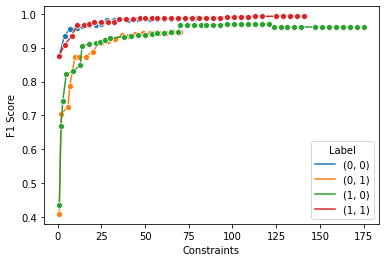

In [9]:
sns.lineplot(data=metrics, x='Constraints', y='F1 Score', hue='Label', marker='o')

In [10]:
with open('data/fidelity-diro2c.pickle', 'wb') as f:
    pickle.dump(metrics, f)

In [75]:
metrics.query('Label == "(0, 1)" and Leafs == 9')

,Precision,Recall,F1 Score,Support,Label,Leafs,Alpha,Rules,Constraints
1,0.780431,0.992165,0.873652,1021.0,"(0, 1)",9.0,0.002558,3.0,10.0


In [76]:
metrics.query('Label == "(1, 0)" and Leafs == 11')

,Precision,Recall,F1 Score,Support,Label,Leafs,Alpha,Rules,Constraints
1,0.905485,0.903199,0.90434,1188.0,"(1, 0)",11.0,0.004537,4.0,14.0


# Additional Material

In [72]:
tree = get_pruned_trees(explanations_per_class['(0, 1)'])[4]

In [74]:
constraints, rules, class_occurences, labels, rule_order = extract_rules(tree, feature_names, comparer.difference_classes, precisions=feature_precisions, latex=True)
for rule in rules:
    print(f'\item if ${rule}$, then $(0, 1)$')

\item if $\mathit{x_1} > 118.5 \land 21.9 < \mathit{x_2} \leq 99.8$, then $(0, 1)$
\item if $93.7 < \mathit{x_1} \leq 118.5 \land 22.0 < \mathit{x_2} \leq 48.8$, then $(0, 1)$
\item if $\mathit{x_1} > 185.8 \land 99.8 < \mathit{x_2} \leq 166.9$, then $(0, 1)$


In [75]:
tree = get_pruned_trees(explanations_per_class['(1, 0)'])[6]

In [76]:
constraints, rules, class_occurences, labels, rule_order = extract_rules(tree, feature_names, comparer.difference_classes, precisions=feature_precisions, latex=True)
for rule in rules:
    print(f'\item if ${rule}$, then $(1, 0)$')

\item if $\mathit{x_1} \leq 38.2 \land -29.9 < \mathit{x_2} \leq 22.1$, then $(1, 0)$
\item if $38.2 < \mathit{x_1} \leq 59.3 \land -11.7 < \mathit{x_2} \leq 22.1$, then $(1, 0)$
\item if $\mathit{x_1} \leq 1.0 \land -79.7 < \mathit{x_2} \leq -29.9$, then $(1, 0)$
\item if $59.3 < \mathit{x_1} \leq 76.4 \land 3.9 < \mathit{x_2} \leq 22.0$, then $(1, 0)$
